In [1]:
library(loadeR)
library(transformeR)
library(visualizeR)

Warning message:
"package 'loadeR' was built under R version 3.6.3"Loading required package: rJava
Warning message:
"package 'rJava' was built under R version 3.6.3"

Loading required package: loadeR.java
Warning message:
"package 'loadeR.java' was built under R version 3.6.3"Java version 21x amd64 by Azul Systems, Inc. detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
Warning message:
"package 'climate4R.UDG' was built under R version 3.6.3"climate4R.UDG version 0.2.6 (2023-06-26) is loaded
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.8.1 (2023-06-22) is loaded
Please use 'citation("loadeR")' to cite this package.
Warning message:
"package 'transformeR' was built under R version 3.6.3"


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded
Please see 'citation("transformeR")' to cite this package.
Warning message:
"package 'visualizeR' was built under R version 3.6.3"visualizeR version 1.6.4 (2023-10-26) is loaded
Please see 'citation("visualizeR")' to cite this package.


In [2]:
pr1 <- readRDS("aemet/pr51_61.rds")
pr2 <- readRDS("aemet/pr62_72.rds")

In [6]:
t1 <- readRDS("aemet/tmax51_61.rds")
t2 <- readRDS("aemet/tmax62_72.rds")

In [4]:
pr <- bindGrid(pr1, pr2, dimension = "time")

In [7]:
tmax <- bindGrid(t1, t2, dimension = "time")

# Quantile

In [10]:
dimension <- dim(pr_h$Data)
print(dimension)

[1] 8036   85  137


In [9]:
pr_h <- pr

In [13]:
for (a in 1:dimension[1]) {
  for (i in 1:dimension[2]) {
    for (j in 1:dimension[3]) {
      if (!is.na(pr_h$Data[a,i,j])) { # Check for missing values
          if (pr_h$Data[a,i,j] <= 0.1) {
              pr_h$Data[a,i,j] <- NaN
            }
          }
        }
      }
  }

In [14]:
seasons <- list(Winter = c(12, 1, 2), Spring = c(3, 4, 5), Summer = c(6, 7, 8), Autumn = c(9, 10, 11))

In [15]:
# Function to apply climatology to a dataset for a specific season and quantile level
ref_quantile <- function(data, quantile) {
    # data: a grid with the data
    # quantile: number of the quantile to calculate
  results <- list()
  for (season_name in names(seasons)) {
    season_month <- seasons[[season_name]]
    season_data <- subsetGrid(data, season = season_month)
    quantile_result <- climatology(season_data, clim.fun = list(FUN = "quantile", probs = quantile, na.rm = TRUE))
    results[[season_name]] <- quantile_result
  }
  return(results)
}

### Data

In [16]:
pr_h <- ref_quantile(pr_h, 0.10)

NOTE: Some data will be lost on year-crossing season subset (see the 'Time slicing' section of subsetGrid documentation for more details)
[2024-03-27 12:06:49] - Computing climatology...
[2024-03-27 12:06:51] - Done.
[2024-03-27 12:06:53] - Computing climatology...
[2024-03-27 12:06:55] - Done.
[2024-03-27 12:06:55] - Computing climatology...
[2024-03-27 12:07:03] - Done.
[2024-03-27 12:07:04] - Computing climatology...
[2024-03-27 12:07:05] - Done.


In [17]:
saveRDS(pr_h, "data_aemet/pr_h_quantile_5172.rds", compress = "xz")

In [18]:
tmax_h <- ref_quantile(tmax, 0.90)

NOTE: Some data will be lost on year-crossing season subset (see the 'Time slicing' section of subsetGrid documentation for more details)
[2024-03-27 12:08:18] - Computing climatology...
[2024-03-27 12:08:21] - Done.
[2024-03-27 12:08:22] - Computing climatology...
[2024-03-27 12:08:26] - Done.
[2024-03-27 12:08:26] - Computing climatology...
[2024-03-27 12:08:29] - Done.
[2024-03-27 12:08:29] - Computing climatology...
[2024-03-27 12:08:31] - Done.


In [19]:
saveRDS(tmax_h, "data_aemet/tmax_quantile_5172.rds", compress = "xz")

# Subset Year Season

In [20]:
# Define the seasons and years to process
seasons <- list(Winter = c(12, 1, 2), Spring = c(3, 4, 5), Summer = c(6, 7, 8), Autumn = c(9, 10, 11))
years <- seq(1951, 1972, by = 1)

processed_data <- function(data){
    # Function to obtain the data by season and year
    # data: a grid with the data
    
    new_data <- lapply(as.character(years), function(y) {
        new_data_year <- list()
        
        for (season_name in names(seasons)) {
            season_months <- seasons[[season_name]]
            
            if (season_name == "Winter") {
                # Winter, include December of the previous year
                if (as.numeric(y) != min(years)) {
                    previous_dec <- subsetGrid(data, year = as.numeric(y) - 1, season = c(12))
                    current_en_feb <- subsetGrid(data, year = as.numeric(y), season = c(1, 2))
                    winter_data <- bindGrid(previous_dec, current_en_feb, dimension = "time")
                    new_data_year[[season_name]] <- winter_data
                } else {
                    current_en_feb <- subsetGrid(data, year = as.numeric(y), season = c(1, 2))
                    new_data_year[[season_name]] <- current_en_feb
                }
            } else {
                # Rest of the seasons
                data_season_year <- subsetGrid(data, year = as.numeric(y), season = season_months)
                new_data_year[[season_name]] <- data_season_year
            }
        }
        
        return(new_data_year)
    })
    
    names(new_data) <- as.character(years)
    
    return(new_data)
}

#### Data

In [21]:
pr_y_s <- processed_data(pr)

In [24]:
saveRDS(pr_y_s, "data_aemet/pr_y_s_5172.rds", compress = "xz")

In [25]:
tmax_y_s <- processed_data(tmax)

In [31]:
saveRDS(tmax_y_s, "data_aemet/tmax_y_s_5172.rds", compress = "xz")

# Binarization

In [26]:
binarization <- function(grid_data, quantile, variable) {
# Iterate over the years in the data grid
  for (year in names(grid_data)) {
    # Iterate over the seasons of each year
    for (season in names(grid_data[[year]])) {
      # Get current station data
      season_data <- grid_data[[year]][[season]]
      season_quantile <- quantile[[season]]
      
      # Dimension of the data
      dims <- dim(season_data$Data)
      # Iterate over dimensions and convert to binary
      for (a in 1:dims[1]) {
        for (i in 1:dims[2]) {
          for (j in 1:dims[3]) {
            if (!is.na(season_data$Data[a, i, j]) && !is.na(season_quantile$Data[1, i, j])) {
              # If it is precipitation
              if(variable == "pr"){
                if (season_data$Data[a, i, j] < season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              # If it is tmax
              } else if (variable == "tmax"){
                if (season_data$Data[a, i, j] > season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              }
            }
          }
        }
      }
      
      # Actualizar el grid de datos con la estación binarizada
      grid_data[[year]][[season]] <- season_data
    }
  }
  
  # Devolver el grid de datos binarizado
  return(grid_data)
}

In [27]:
tmax <- binarization(tmax_y_s, tmax_h, "tmax")

In [32]:
saveRDS(tmax, "data_aemet/tmax_binarized_5172.rds", compress = "xz")

In [28]:
pr <- binarization(pr_y_s, pr_h, "pr")

In [33]:
saveRDS(pr, "data_aemet/pr_binarized_5172.rds", compress = "xz")

# CE

In [2]:
tmax <- readRDS("data_aemet/tmax_binarized_5172.rds")
pr <- readRDS("data_aemet/pr_binarized_5172.rds")

In [3]:
# Create a function that iter over the years and seasons of two datagrids and execute the function gridArithmetics
compound_event <- function(grid1, grid2) {
  grid3 <- grid1
  # Iterate over the years in the grid
  for (year in names(grid1)) {
    # Iterate over the seasons in each year
    for (season in names(grid1[[year]])) {
      # Get the data of the current season
      season_data1 <- grid1[[year]][[season]]
      season_data2 <- grid2[[year]][[season]]
      # Apply the function to the data
      event_compount <- gridArithmetics(season_data1, season_data2, operator = "*")
      # Update the data grid with the result
      grid3[[year]][[season]] <- event_compount
    }
  }
  # Return the updated grid
  return(grid3)
}

In [4]:
CE <- compound_event(pr, tmax)

In [8]:
saveRDS(CE, "data_aemet/CE_5172.rds", compress = "xz")

# Sum CE

In [5]:
capa_tierra <- readRDS("capa_tierra_aemet.rds")

In [6]:
# Create a function that iter over the years and seasons of one data grid and execute the function climatology to summarize the data
sum_events <- function(grid) {
  grid1 <- grid
  # Iterate over the years in the grid
  for (year in names(grid)) {
    # Iterate over the seasons in each year
    for (season in names(grid[[year]])) {
      # Get the data of the current season
      season_data1 <- grid[[year]][[season]]
      # Apply the function to the data
      sum_events <- climatology(season_data1, clim.fun = list(FUN = "sum", na.rm = TRUE))
      sum_events <- gridArithmetics(sum_events, capa_tierra, operator = "*")
      # Update the data grid with the result
      grid1[[year]][[season]] <- sum_events
    }
  }
  # Return the updated grid
  return(grid1)
}

In [7]:
sumCE <- sum_events(CE)

[2024-03-27 12:38:47] - Computing climatology...
[2024-03-27 12:38:47] - Done.
[2024-03-27 12:38:47] - Computing climatology...
[2024-03-27 12:38:47] - Done.
[2024-03-27 12:38:47] - Computing climatology...
[2024-03-27 12:38:47] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:48] - Computing climatology...
[2024-03-27 12:38:48] - Done.
[2024-03-27 12:38:49] - Computing climatology...
[2024-03-27 12:38:49] - Done.
[2024-03-27 12:38:49] - Computing climatology...
[20

In [9]:
saveRDS(sumCE, "data_aemet/sumCE_5172.rds", compress = "xz")

# Group

In [10]:
# Función para realizar bindGrid de una estación específica para varios años
bindGridEstaciones <- function(datos, estacion) {
  # Extraemos los años disponibles en los datos
  years <- names(datos)
  
  # Creamos una lista para almacenar los grids de cada año
  lista_grids <- list()
  
  # Iteramos sobre los años
  for (year in years) {
    # Obtenemos el grid para la estación especificada
    grid <- datos[[year]][[estacion]]
    # Lo añadimos a la lista
    lista_grids[[year]] <- grid
  }
  
  # Realizamos el bindGrid con todos los grids de la lista
  resultado <- bindGrid(lista_grids, dimension = "time", skip.temporal.check = TRUE)
  return(resultado)
}

In [11]:
# Crear un vector con los nombres de las estaciones
estaciones <- c("Winter", "Spring", "Summer", "Autumn")

# Crear una lista para almacenar los resultados
dataPeriod <- list()

# Iterar sobre las estaciones
for (estacion in estaciones) {
  # Obtener los datos para la estación actual
  datos_estacion <- bindGridEstaciones(sumCE, estacion = estacion)
  datos_estacion <- climatology(datos_estacion, clim.fun = list(FUN = "sum", na.rm = TRUE))
  datos_estacion <- gridArithmetics(datos_estacion, capa_tierra, operator = "*")
  
  # Almacenar los resultados en la lista
  dataPeriod[[estacion]] <- datos_estacion
}

[2024-03-27 12:40:41] - Computing climatology...
[2024-03-27 12:40:41] - Done.
[2024-03-27 12:40:41] - Computing climatology...
[2024-03-27 12:40:41] - Done.
[2024-03-27 12:40:42] - Computing climatology...
[2024-03-27 12:40:42] - Done.
[2024-03-27 12:40:42] - Computing climatology...
[2024-03-27 12:40:42] - Done.


In [13]:
fullPeriod <- bindGrid(dataPeriod$Winter , dataPeriod$Spring, dataPeriod$Summer, dataPeriod$Autumn, dimension = "member", skip.temporal.check = TRUE)

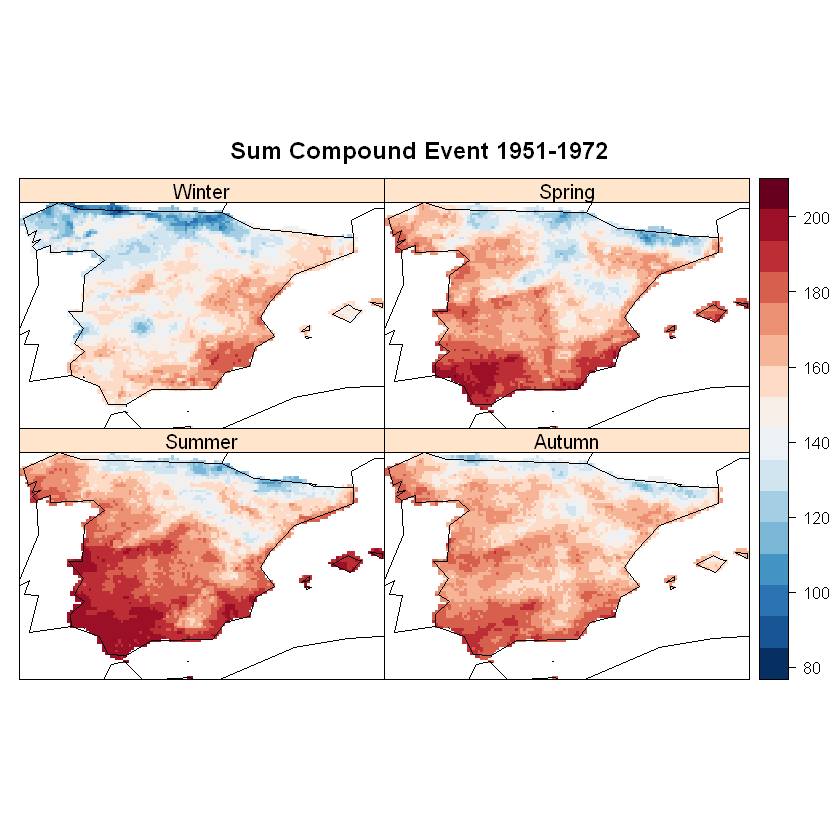

In [18]:
spatialPlot(fullPeriod, color.theme = "RdBu", rev.colors = TRUE, as.table = TRUE, names.attr = c("Winter", "Spring", "Summer", "Autumn"), backdrop.theme = "countries", main = "Sum Compound Event 1951-1972")

# Trend 1

In [19]:
winter <- bindGridEstaciones(sumCE, estacion = "Winter")
spring <- bindGridEstaciones(sumCE, estacion = "Spring")
summer <- bindGridEstaciones(sumCE, estacion = "Summer")
autumn <- bindGridEstaciones(sumCE, estacion = "Autumn")

[2024-03-27 12:46:21] - Computing climatology...
Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning messa

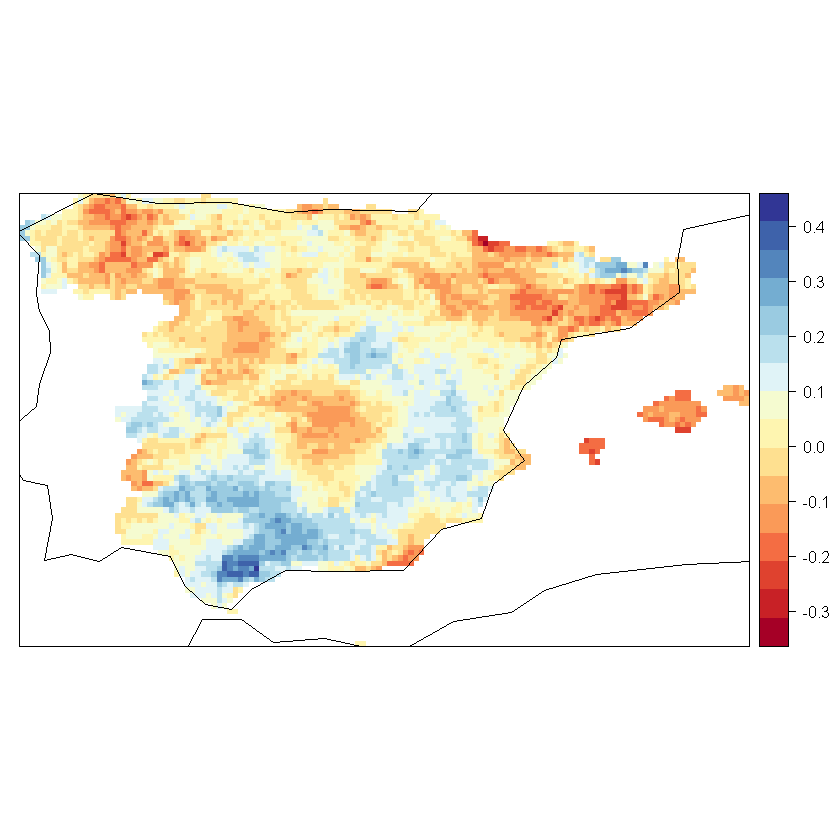

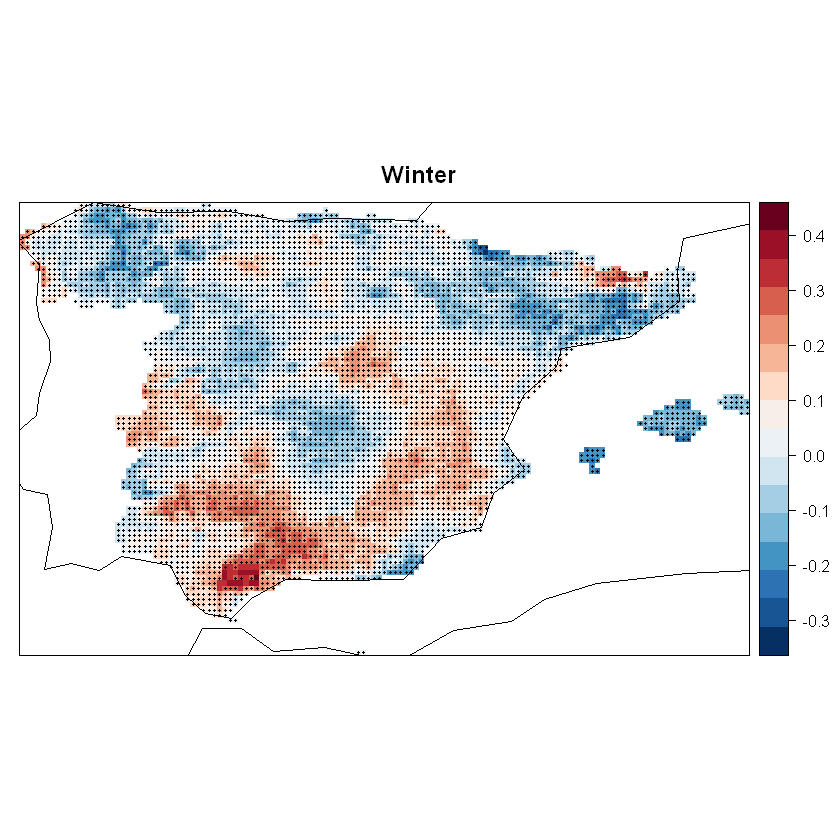

In [20]:
dates.winter <- getRefDates(winter)

tau.winter <- climatology(winter,
                            clim.fun = list(FUN = "trend.1D", dates = dates.winter, method = "kendall"))
spatialPlot(tau.winter, backdrop.theme = "coastline")
# Adding significant trend points is usually needed: 
pval.winter <- climatology(winter,
                            clim.fun = list(FUN = "trend.1D",
                                            dates = dates.winter,
                                            method = "kendall",
                                            return.pvalue = TRUE))
points.winter <- visualizeR::map.stippling(clim = pval.winter, threshold = 0.05, condition = "GE", 
                                        pch = 19, cex = .25, col = "black")
spatialPlot(tau.winter, backdrop.theme = "coastline", sp.layout = list(points.winter), main = "Winter", color.theme = "RdBu", rev.colors = TRUE)

[2024-03-27 12:49:15] - Computing climatology...
Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning messa

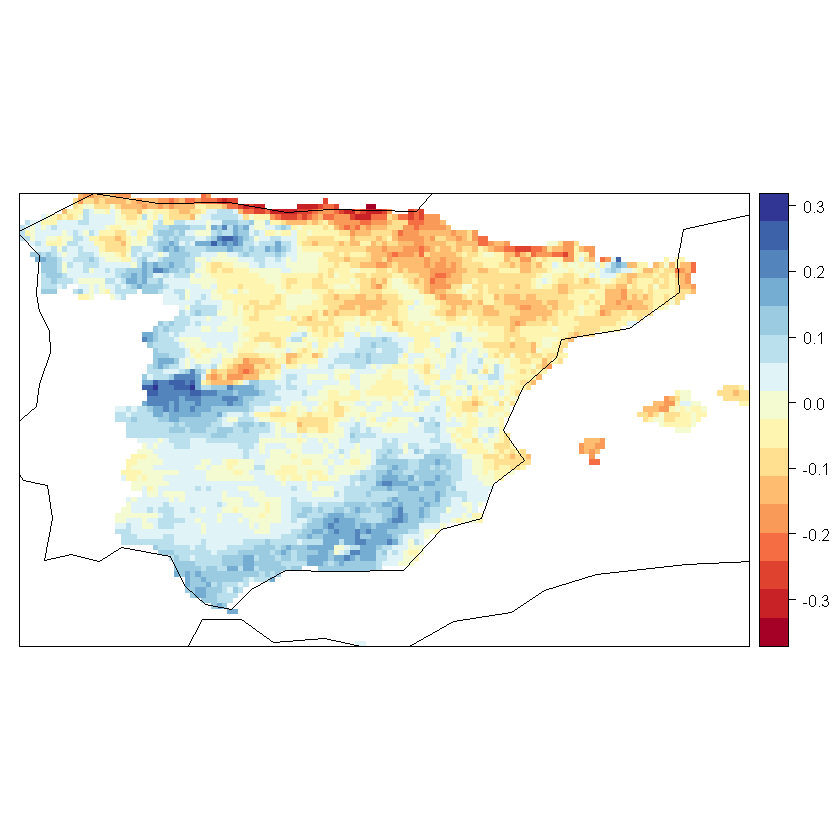

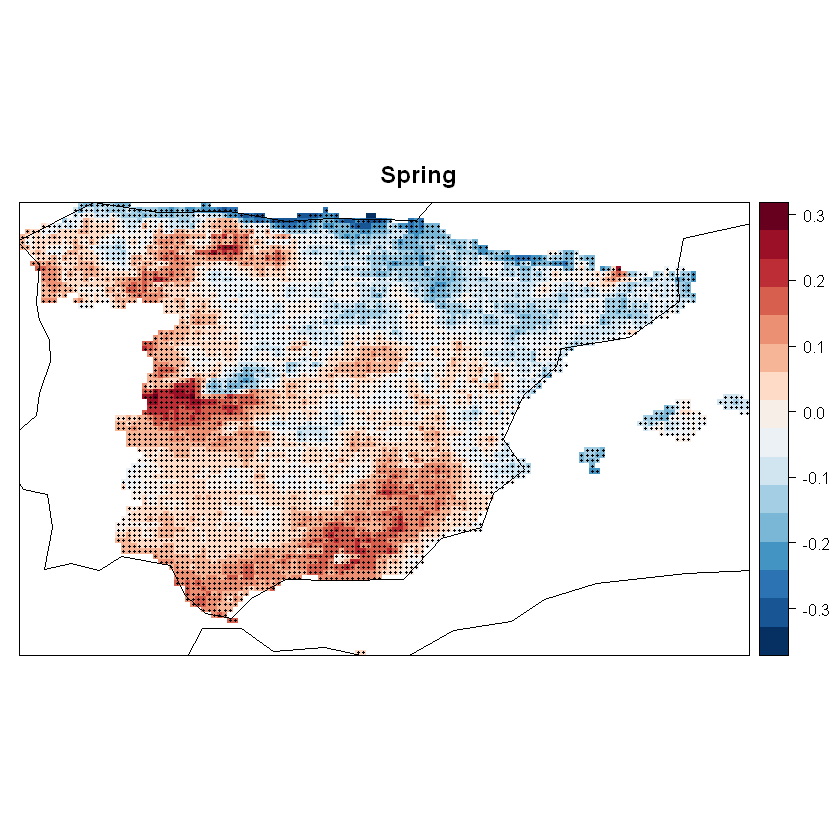

In [21]:
dates.spring <- getRefDates(spring)
tau.spring <- climatology(spring,
                            clim.fun = list(FUN = "trend.1D", dates = dates.spring, method = "kendall"))
spatialPlot(tau.spring, backdrop.theme = "coastline")
# Adding significant trend points is usually needed: 
pval.spring <- climatology(spring,
                            clim.fun = list(FUN = "trend.1D",
                                            dates = dates.spring,
                                            method = "kendall",
                                            return.pvalue = TRUE))
points.spring <- visualizeR::map.stippling(clim = pval.spring, threshold = 0.05, condition = "GE", 
                                        pch = 19, cex = .25, col = "black")
spatialPlot(tau.spring, backdrop.theme = "coastline", sp.layout = list(points.spring), main = "Spring", color.theme = "RdBu", rev.colors = TRUE)

In [ ]:
dates.summer <- getRefDates(summer)
tau.summer <- climatology(summer,
                            clim.fun = list(FUN = "trend.1D", dates = dates.summer, method = "kendall"))
# spatialPlot(tau.summer, backdrop.theme = "coastline")
# Adding significant trend points is usually needed: 
pval.summer <- climatology(summer,
                            clim.fun = list(FUN = "trend.1D",
                                            dates = dates.summer,
                                            method = "kendall",
                                            return.pvalue = TRUE))
points.summer <- visualizeR::map.stippling(clim = pval.summer, threshold = 0.05, condition = "GE", 
                                        pch = 19, cex = .25, col = "black")
spatialPlot(tau.summer, backdrop.theme = "coastline", sp.layout = list(points.summer), main = "Summer", color.theme = "RdBu", rev.colors = TRUE)

In [ ]:
dates.autumn <- getRefDates(autumn)
tau.autumn <- climatology(autumn,
                            clim.fun = list(FUN = "trend.1D", dates = dates.autumn, method = "kendall"))
# spatialPlot(tau.autumn, backdrop.theme = "coastline")
# Adding significant trend points is usually needed: 
pval.autumn <- climatology(autumn,
                            clim.fun = list(FUN = "trend.1D",
                                            dates = dates.autumn,
                                            method = "kendall",
                                            return.pvalue = TRUE))
points.autumn <- visualizeR::map.stippling(clim = pval.autumn, threshold = 0.05, condition = "GE", 
                                        pch = 19, cex = .25, col = "black")
spatialPlot(tau.autumn, backdrop.theme = "coastline", sp.layout = list(points.autumn), main = "Autumn", color.theme = "RdBu", rev.colors = TRUE)

All

In [ ]:
tau <- bindGrid(tau.winter, tau.spring, tau.summer, tau.autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(tau, backdrop.theme = "coastline",   names.attr = c("Winter", "Spring", "Summer", "Autumn"), main = "Trend 1971-2015", as.table = TRUE)

# Trend 2

In [22]:
library(climate4R.value)
library(VALUE)

Warning message:
"package 'climate4R.value' was built under R version 3.6.3"Loading required package: VALUE
Warning message:
"package 'VALUE' was built under R version 3.6.3"---------------------------------------------- 
| VALUE version 2.2.4 (2023-06-22) is loaded |
|         http://www.value-cost.eu           |
----------------------------------------------


In [23]:
winter <- bindGridEstaciones(sumCE, "Winter")
spring <- bindGridEstaciones(sumCE, "Spring")
summer <- bindGridEstaciones(sumCE, "Summer")
autumn <- bindGridEstaciones(sumCE, "Autumn")

[2024-03-27 13:04:17] Computing member 1 out of 1
[2024-03-27 13:05:13] Done.
[2024-03-27 13:05:13] Computing member 1 out of 1
[2024-03-27 13:06:06] Done.
[2024-03-27 13:06:06] - Computing climatology...
Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value w

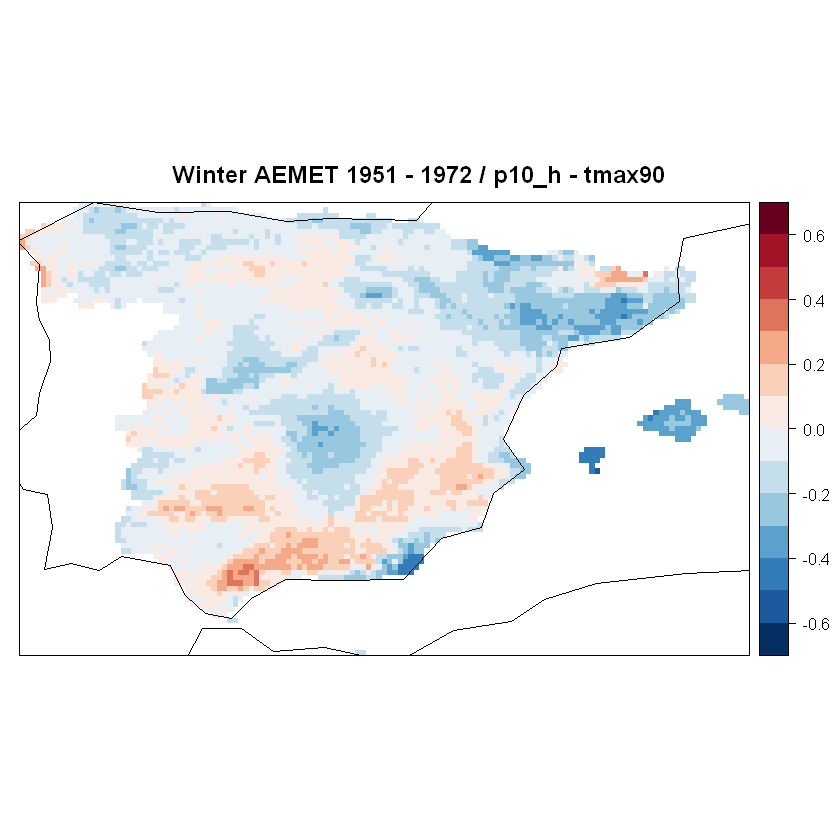

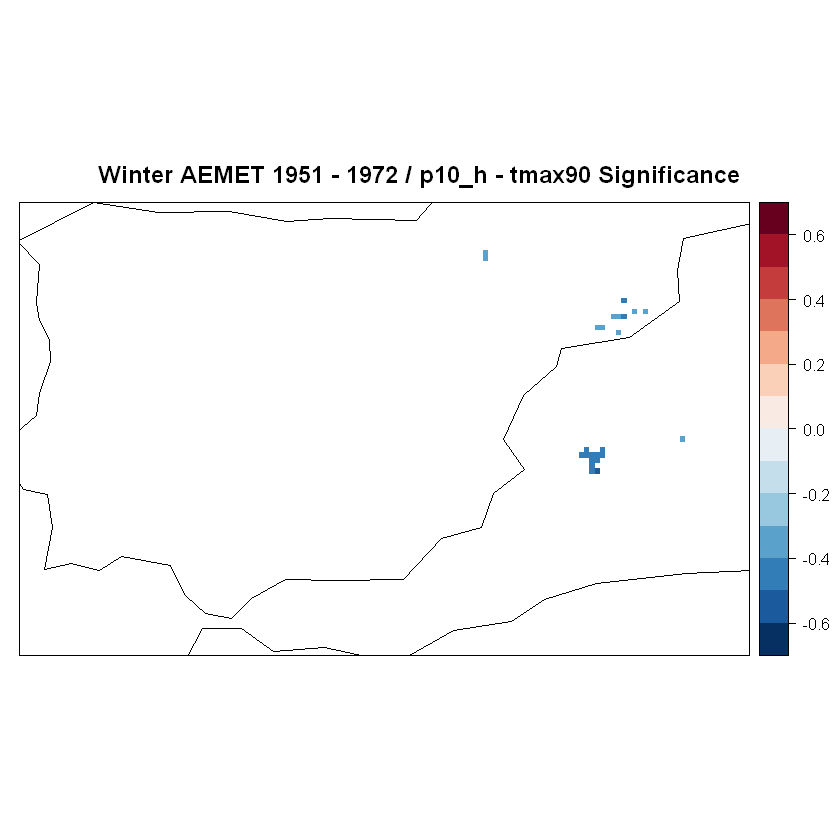

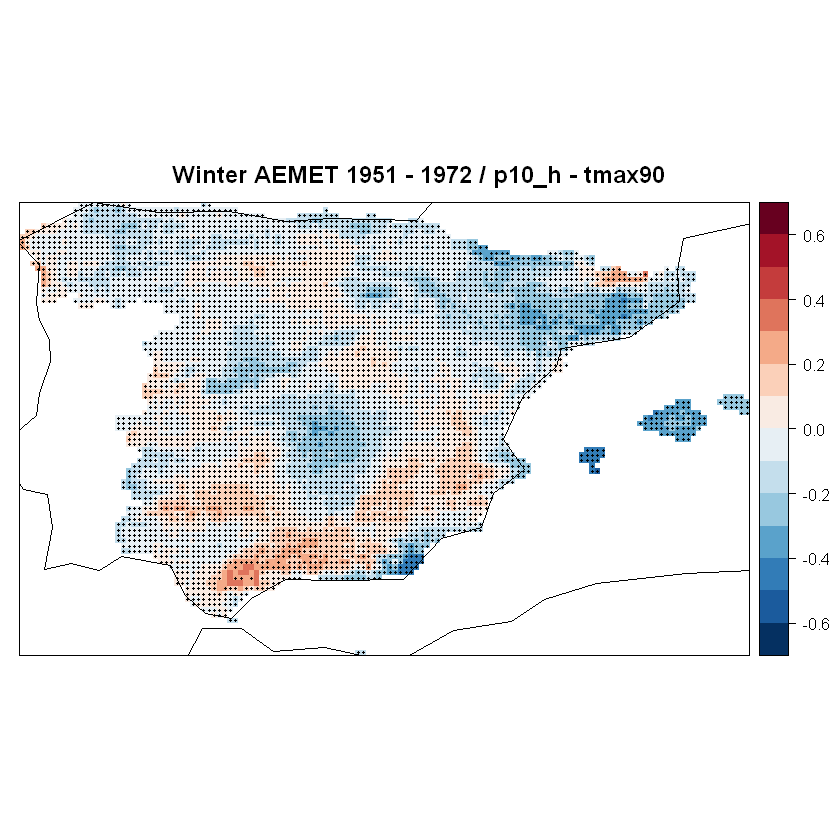

In [28]:
trend.winter <- valueIndex(winter, index.code = "Trend", return.NApercentage = FALSE) # La pendiente
sig.winter <- valueIndex(winter, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
sig.winter$Data[sig.winter$Data == 0] <- NA
trend.sig.winter <- gridArithmetics(trend.winter, sig.winter, operator = "*")


pval.winter <- climatology(winter, clim.fun = list(FUN = "trend.1D", dates = getRefDates(winter), method = "kendall", return.pvalue = TRUE))
points.winter <- visualizeR::map.stippling(pval.winter, thereshold = 0.05, condition = "GE", pch = 19, cex = 0.25, col = "black")

# Representaciones
spatialPlot(trend.winter, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by =0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Winter AEMET 1951 - 1972 / p10_h - tmax90")
spatialPlot(trend.sig.winter, backdrop.theme = "coastline", color.theme = "RdBu", rev.colors = TRUE, main = paste("Winter AEMET 1951 - 1972 / p10_h - tmax90", "Significance"), at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7)
spatialPlot(trend.winter, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Winter AEMET 1951 - 1972 / p10_h - tmax90", sp.layout = list(points.winter))


[2024-03-27 13:07:17] Computing member 1 out of 1


[2024-03-27 13:08:05] Done.
[2024-03-27 13:08:05] Computing member 1 out of 1
[2024-03-27 13:09:04] Done.
[2024-03-27 13:09:04] - Computing climatology...
Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = t

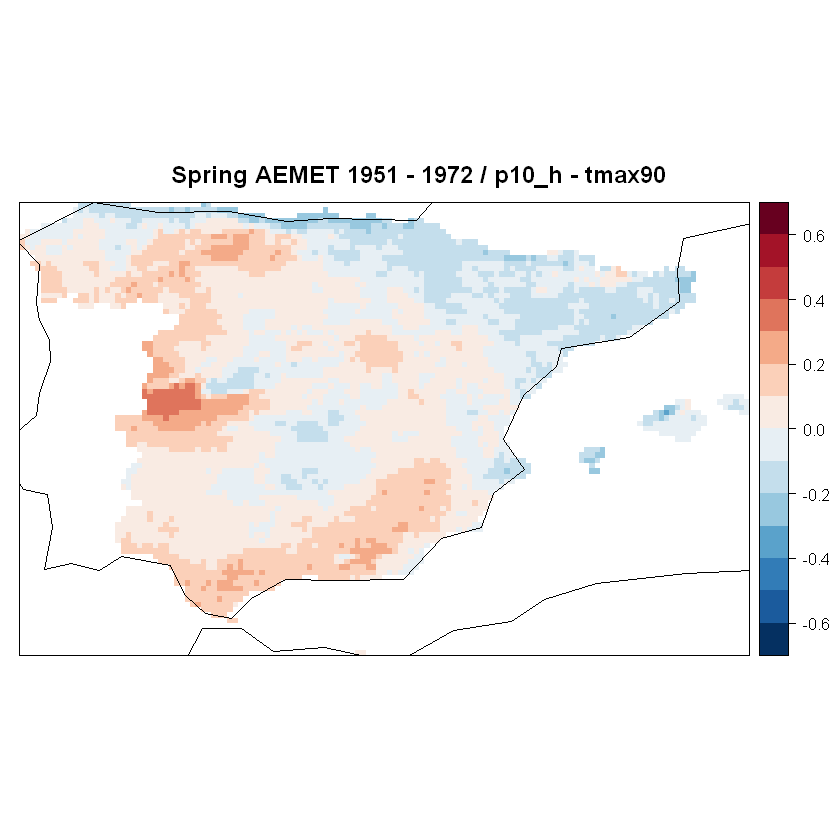

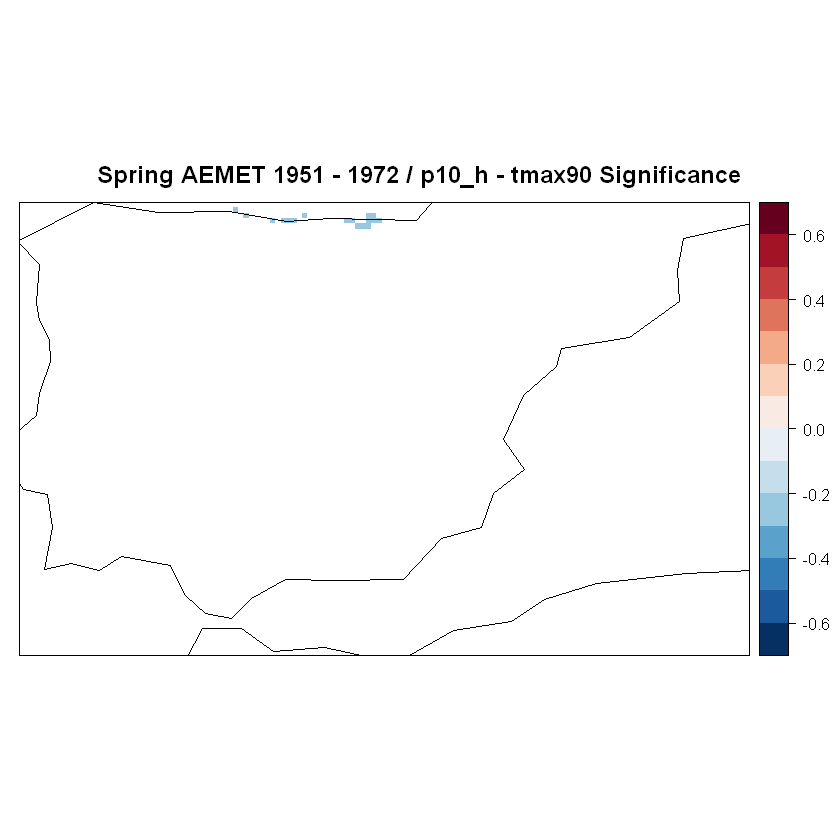

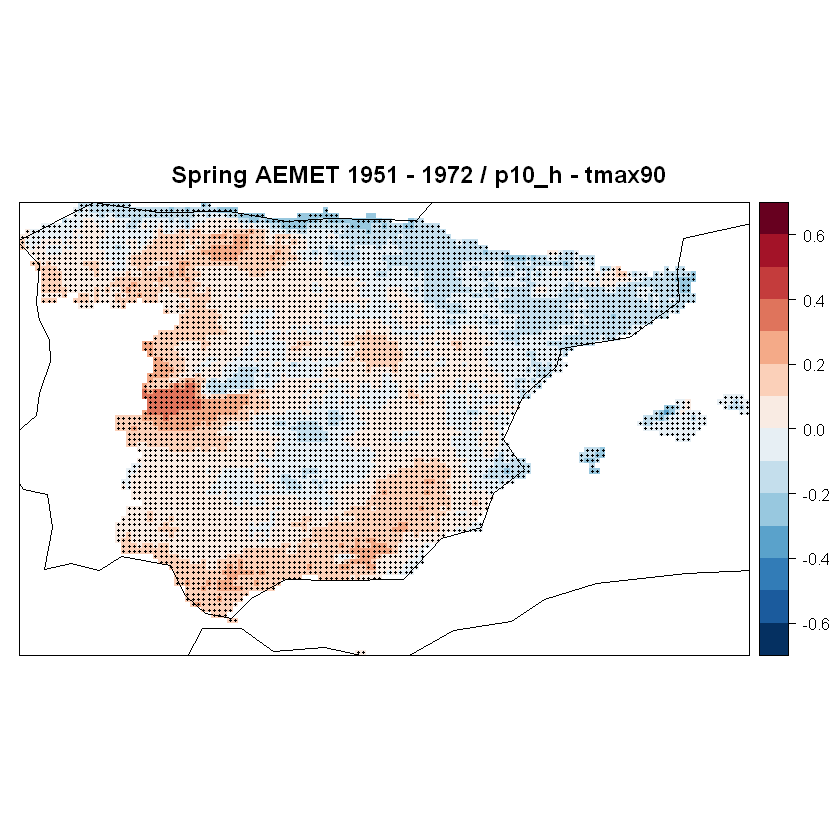

In [29]:
trend.spring <- valueIndex(spring, index.code = "Trend", return.NApercentage = FALSE) # La pendiente
sig.spring <- valueIndex(spring, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
sig.spring$Data[sig.spring$Data == 0] <- NA
trend.sig.spring <- gridArithmetics(trend.spring, sig.spring, operator = "*")


pval.spring <- climatology(spring, clim.fun = list(FUN = "trend.1D", dates = getRefDates(spring), method = "kendall", return.pvalue = TRUE))
points.spring <- visualizeR::map.stippling(pval.spring, thereshold = 0.05, condition = "GE", pch = 19, cex = 0.25, col = "black")

# Representaciones
spatialPlot(trend.spring, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by =0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Spring AEMET 1951 - 1972 / p10_h - tmax90")
spatialPlot(trend.sig.spring, backdrop.theme = "coastline", color.theme = "RdBu", rev.colors = TRUE, main = paste("Spring AEMET 1951 - 1972 / p10_h - tmax90", "Significance"), at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7)
spatialPlot(trend.spring, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Spring AEMET 1951 - 1972 / p10_h - tmax90", sp.layout = list(points.spring))

[2024-03-27 13:09:47] Computing member 1 out of 1


[2024-03-27 13:10:37] Done.
[2024-03-27 13:10:37] Computing member 1 out of 1
[2024-03-27 13:11:31] Done.
[2024-03-27 13:11:31] - Computing climatology...
Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = t

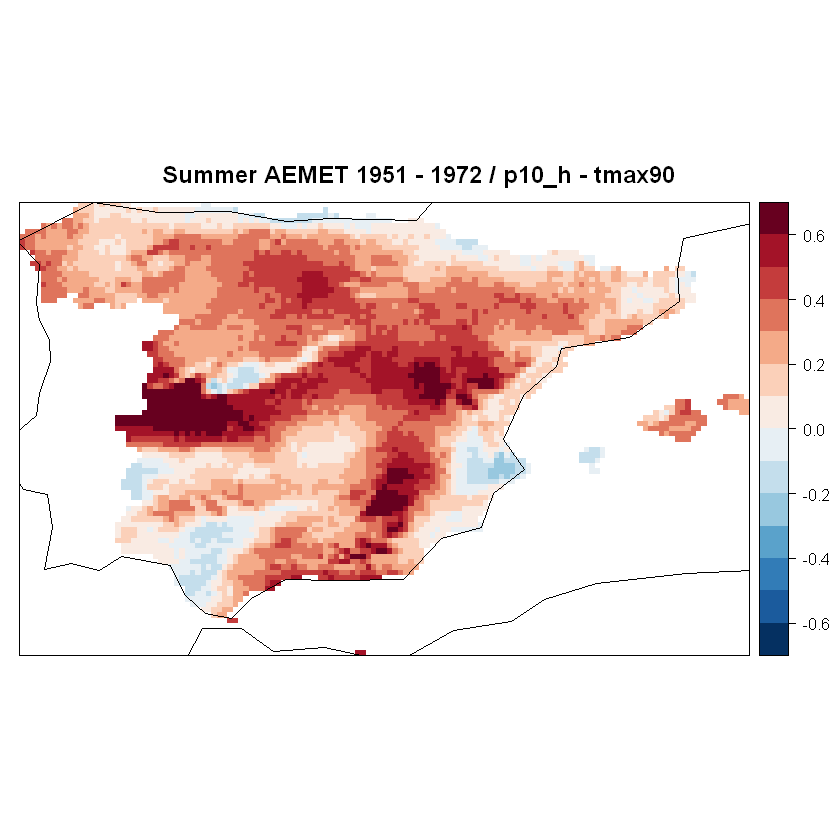

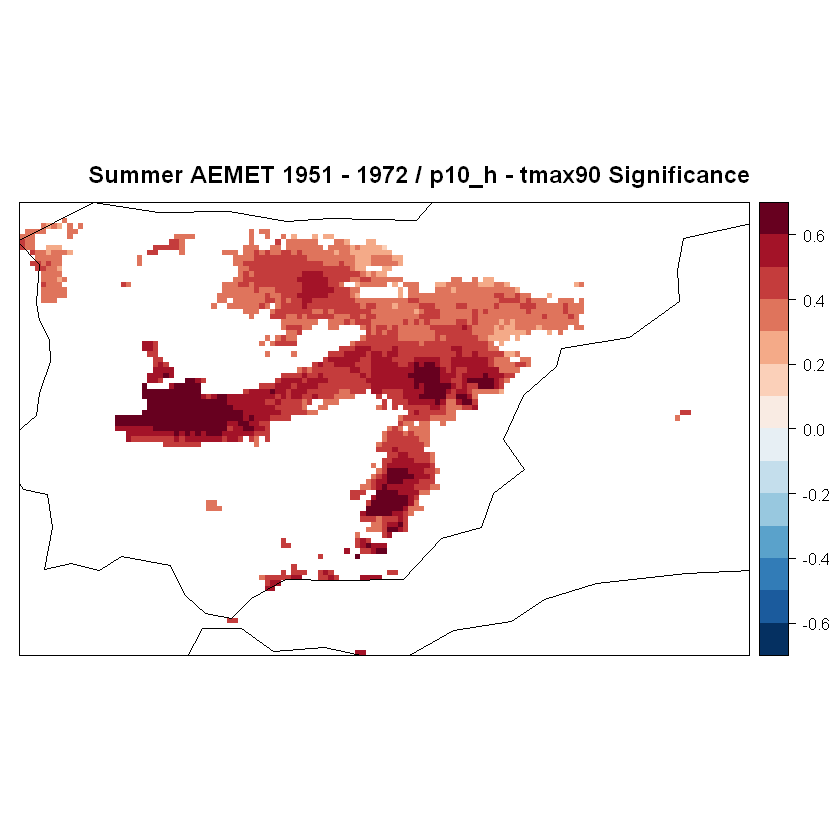

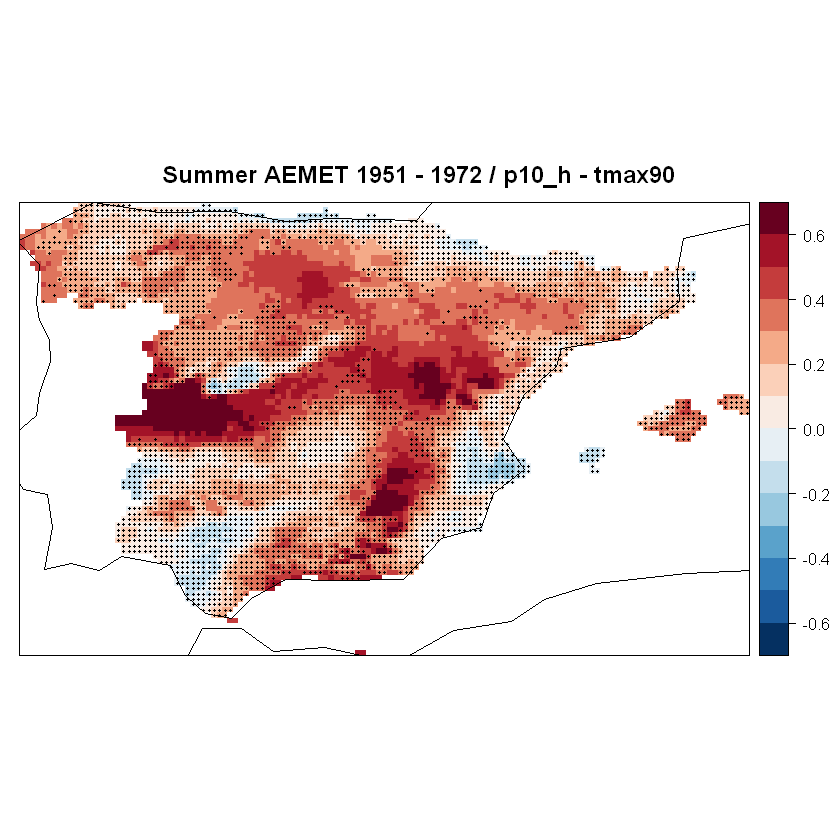

In [30]:
trend.summer <- valueIndex(summer, index.code = "Trend", return.NApercentage = FALSE) # La pendiente
sig.summer <- valueIndex(summer, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
sig.summer$Data[sig.summer$Data == 0] <- NA
trend.sig.summer <- gridArithmetics(trend.summer, sig.summer, operator = "*")


pval.summer <- climatology(summer, clim.fun = list(FUN = "trend.1D", dates = getRefDates(summer), method = "kendall", return.pvalue = TRUE))
points.summer <- visualizeR::map.stippling(pval.summer, thereshold = 0.05, condition = "GE", pch = 19, cex = 0.25, col = "black")

# Representaciones
spatialPlot(trend.summer, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by =0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Summer AEMET 1951 - 1972 / p10_h - tmax90")
spatialPlot(trend.sig.summer, backdrop.theme = "coastline", color.theme = "RdBu", rev.colors = TRUE, main = paste("Summer AEMET 1951 - 1972 / p10_h - tmax90", "Significance"), at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7)
spatialPlot(trend.summer, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Summer AEMET 1951 - 1972 / p10_h - tmax90", sp.layout = list(points.summer))

[2024-03-27 13:12:20] Computing member 1 out of 1


[2024-03-27 13:13:17] Done.
[2024-03-27 13:13:17] Computing member 1 out of 1
[2024-03-27 13:14:12] Done.
[2024-03-27 13:14:12] - Computing climatology...
Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = ts, y = x, method = method, conf.level = conf.level):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = t

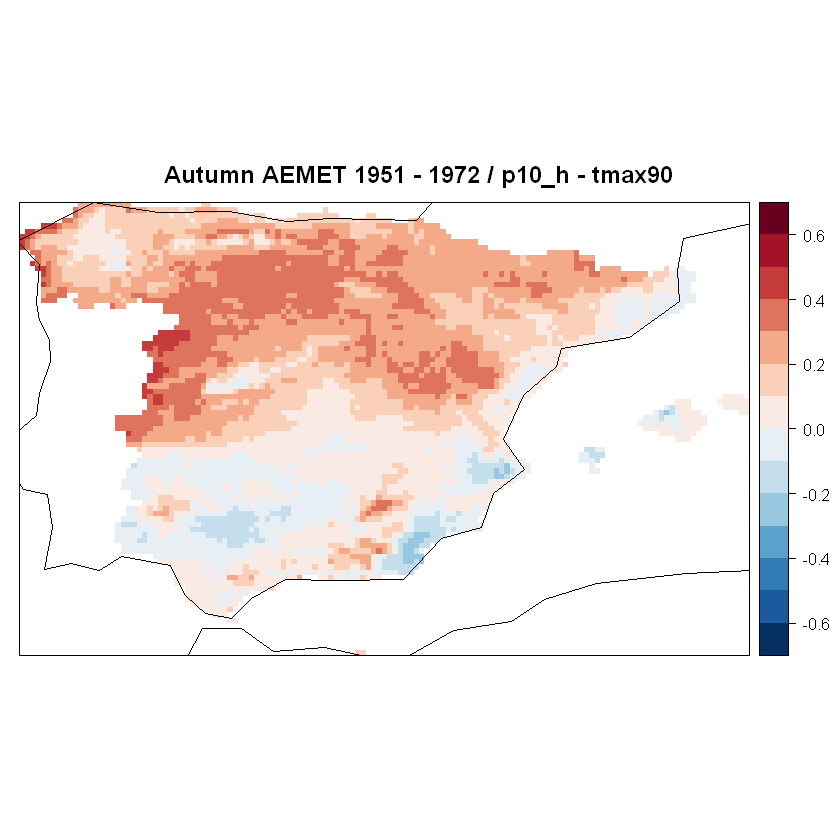

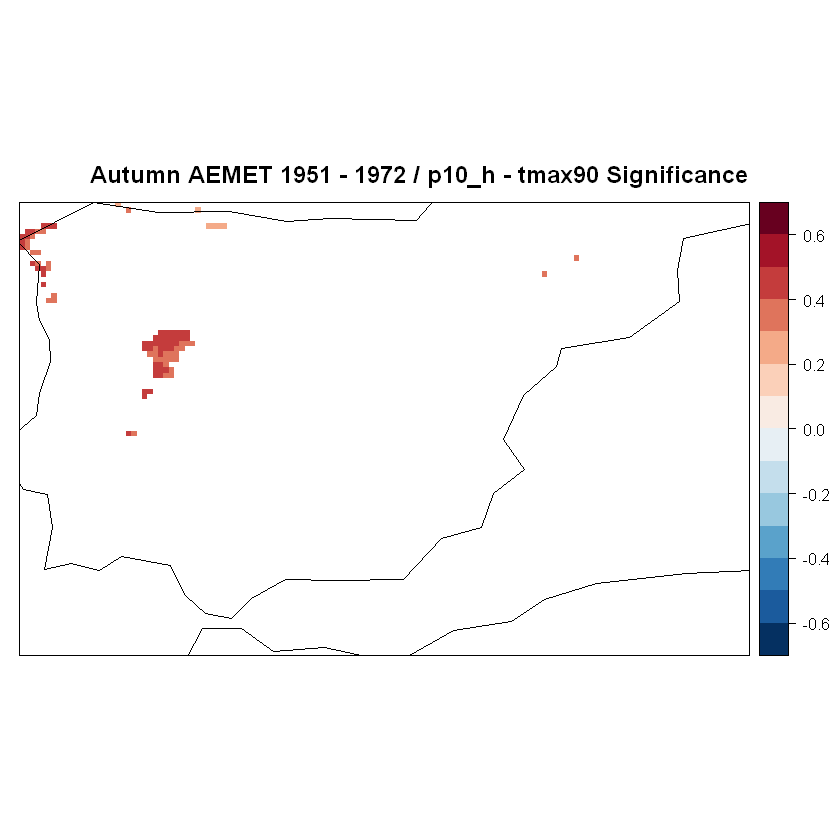

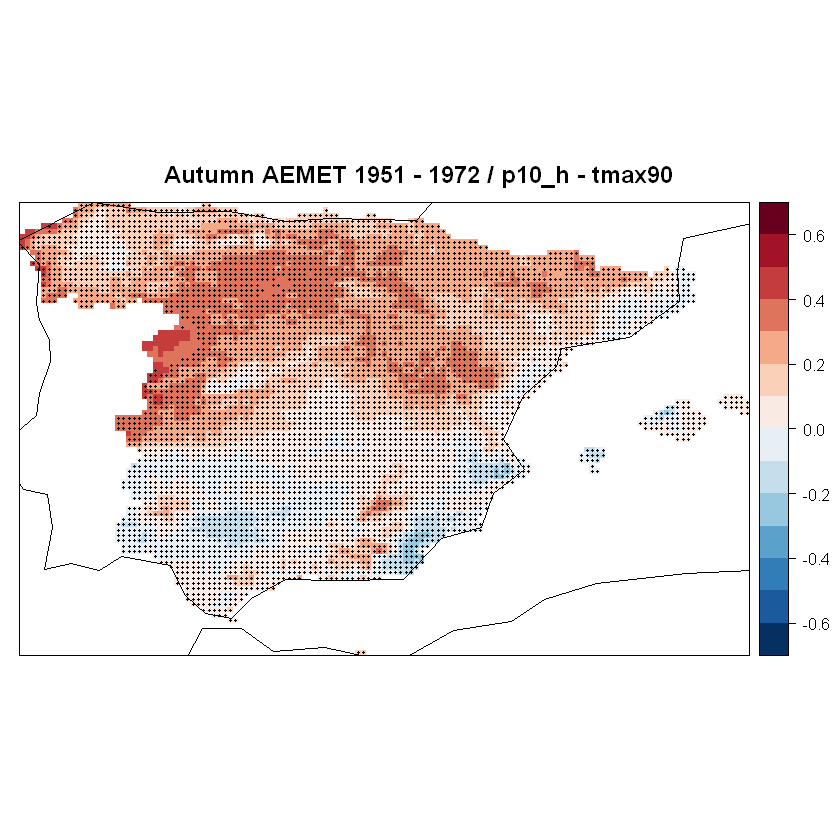

In [31]:
trend.autumn <- valueIndex(autumn, index.code = "Trend", return.NApercentage = FALSE) # La pendiente
sig.autumn <- valueIndex(autumn, index.code = "TrendSig", return.NApercentage = FALSE) # La significancia (1 o 0)
# Si significancia es 0 entonces la pendiente no es significativa = NA
sig.autumn$Data[sig.autumn$Data == 0] <- NA
trend.sig.autumn <- gridArithmetics(trend.autumn, sig.autumn, operator = "*")


pval.autumn <- climatology(autumn, clim.fun = list(FUN = "trend.1D", dates = getRefDates(autumn), method = "kendall", return.pvalue = TRUE))
points.autumn <- visualizeR::map.stippling(pval.autumn, thereshold = 0.05, condition = "GE", pch = 19, cex = 0.25, col = "black")

# Representaciones
spatialPlot(trend.autumn, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by =0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Autumn AEMET 1951 - 1972 / p10_h - tmax90")
spatialPlot(trend.sig.autumn, backdrop.theme = "coastline", color.theme = "RdBu", rev.colors = TRUE, main = paste("Autumn AEMET 1951 - 1972 / p10_h - tmax90", "Significance"), at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7)
spatialPlot(trend.autumn, backdrop.theme = "coastline", color.theme = "RdBu", at = seq(-0.7, 0.7, by = 0.1), set.max = 0.7, set.min = -0.7, rev.colors = TRUE, main = "Autumn AEMET 1951 - 1972 / p10_h - tmax90", sp.layout = list(points.autumn))

All

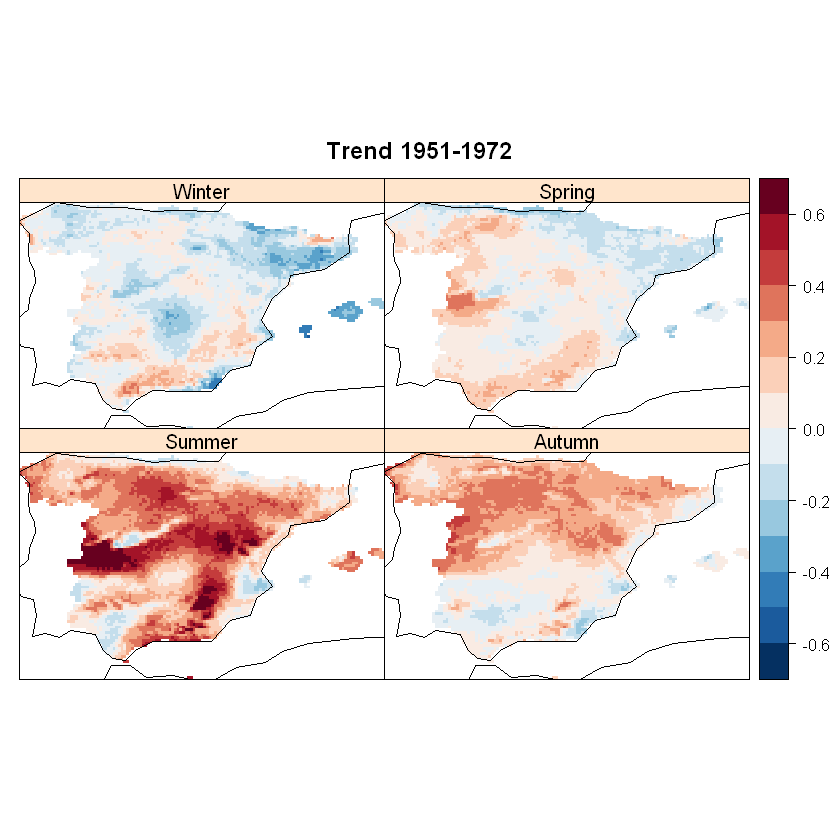

In [32]:
trends <- bindGrid(trend.winter, trend.spring, trend.summer, trend.autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(trends, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), main = "Trend 1951-1972", as.table = TRUE, color.theme = "RdBu", rev.colors = TRUE, at = seq(-0.7, 0.7, by =0.1), set.max = 0.7, set.min = -0.7)